In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [327]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [328]:
import sys
sys.path.append('..')
from dataset import batcher

In [329]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [421]:
# Get test split
test_batcher = batcher.Batcher(bucket=False, shuffle=False, split='test', repeat=1, batch_size=652).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 8)


In [424]:
# Load model
experiments = ['imagery_sample_vgg_regression_ms_nightlights']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [425]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-02-05 12:55:19.069223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[ 0.11199478]
 [ 0.36675265]
 [-0.40624148]
 [-0.3635358 ]
 [-0.31285703]
 [-0.03130198]
 [ 0.2064989 ]
 [-0.01330349]
 [-0.40580124]
 [ 0.17229855]
 [-0.452028  ]
 [ 0.8571206 ]
 [-0.2626052 ]
 [-0.38924968]
 [ 0.88788563]
 [-0.41591585]
 [-0.17974159]
 [ 2.2323089 ]
 [-0.11108126]
 [-0.44819784]
 [ 2.0916293 ]
 [-0.3894797 ]
 [ 0.11199478]
 [-0.18972266]
 [-0.45441577]
 [-0.4142437 ]
 [-0.25925875]
 [ 0.14451337]
 [-0.41425252]
 [ 0.08949205]
 [-0.428404  ]
 [ 1.404407  ]
 [-0.42307997]
 [-0.44021   ]
 [-0.08327812]
 [-0.45519805]
 [ 0.23650675]
 [-0.37078696]
 [-0.18161912]
 [ 0.33875167]
 [ 0.459383  ]
 [-0.370776  ]
 [-0.38692313]
 [-0.34292075]
 [-0.27504617]
 [ 0.05437288]
 [ 0.4435144 ]
 [-0.31204218]
 [ 0.27937   ]
 [ 0.28768224]
 [-0.4829303 ]
 [-0.45738918]
 [-0.4357767 ]
 [ 0.29493418]
 [-0.4299071 ]
 [-0.43991297]
 [-0.4369285 ]
 [-0.4718393 ]
 [-0.3115286 ]
 [-0.3649181 ]
 [-0.47351122]
 [-0.14505011]
 [-0.21257621]
 [-0.3830651 ]
 [ 1.3664953 ]
 [-0.3249641 ]
 [ 1.40440

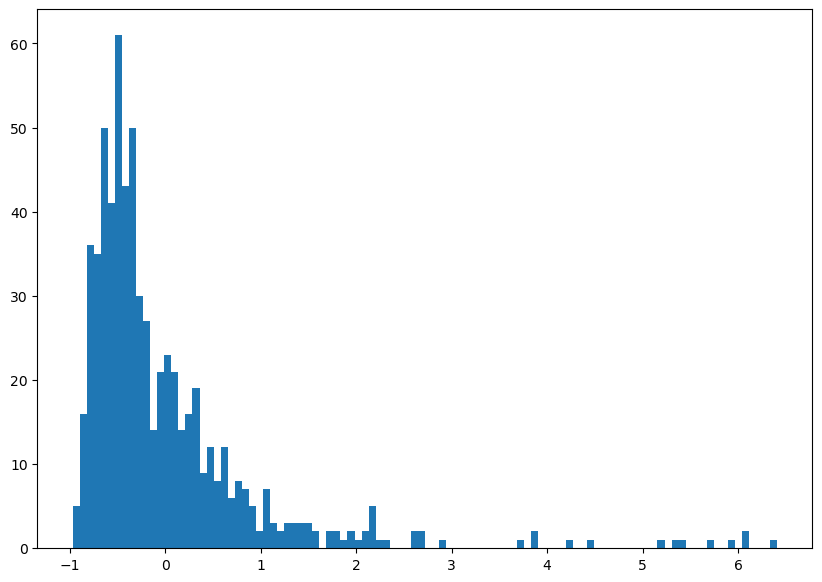

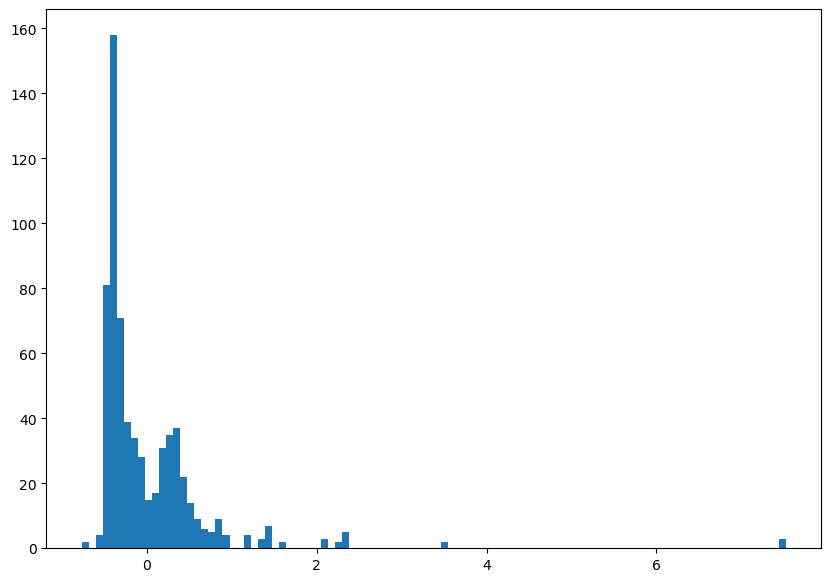

In [426]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()


r2 = pearsonr(y_true, y_preds)[0]

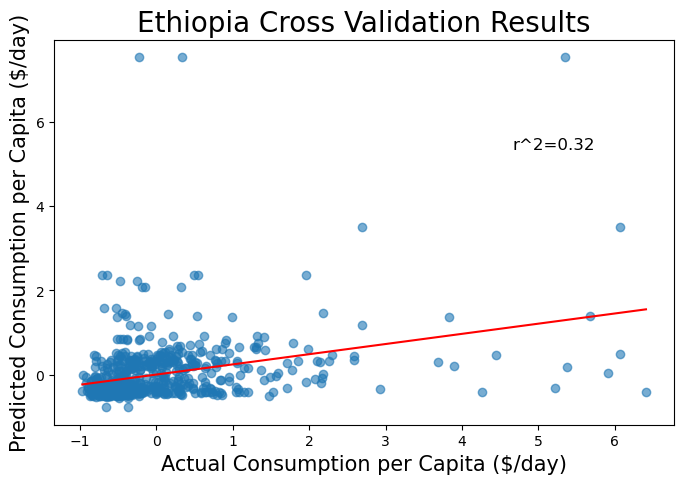

In [427]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([np.min(y_true), 10])
plt.show()